# "Does reducing numerical precision affect real world datasets?"
> "Reducing numerical precision is a way to save memory in pandas, but does it make a difference to the conclusions that we might draw from real world datasets?"

- toc: true
- badges: false
- comments: false
- author: Martin
- categories: [pandas, numpy, kaggle]

### Executive summary

Switching from 64 bit to 32 bit precision for floating point data in pandas saves memory and has virtually no effect on the data, as long as the values aren't greater than around 10<sup>300</sup> 

### Slightly longer summary

- I wrote code to download ~1,000 real world datasets from kaggle and look at summary statistics and linear regressions of floating point columns in both 64 and 32 bit precision
- The final analysis involved ~1,000 datasets, ~8,000 data files, ~500,000,000 individual floating point values and ~500,000 linear regressions. 
- Changing to 32 bit precision introduced a mean proportional error of around 10<sup>-8</sup> in the summary statistics, with the worst affected columns having a proportional error of around 10<sup>-6</sup>
- For linear regressions, the mean proportional change in slope and intercept was on the order of 10<sup>-6</sup>
- A small number of outliers with near-zero slope (representing uninteresting relationships) had larger proportional errors
- In ~400,000 valid linear regressions I was unable to find any relationships whose significance at the 5% level was changed by moving from 64 to 32 bit precision
- For real world datasets, switching from 64 to 32 bit floating point precision is overwhelmingly unlikely to alter our conclusions about the data, and is an easy way to reduce memory usage. 


## Introduction

As you've probably noticed, this is a longish article, so grab a cup of coffee if you're planning to read it all. If you're already familiar with floating point precision and error in pandas you can probably skip part one. Most of the methods stuff is in part two, so if you just want to see the results, skip to part three. Also, just to head off the obvious criticism, I think that most of the conclusions of this article could have been arrived at by pure reasoning, without looking at any data at all. But hopefully some folks will, like me, be more satisfied by empirical data :-)

Obviously, I think that pandas is wonderful :-) But it has a number of quirks, among them a reputation for being memory hungry. There are no shortage of articles online discussing how to fit large dataframes in memory, and there are a number of well established techniques (there's a whole chapter on the subject in the [Drawing from Data book](https://drawingfromdata.com/book/), and also an extended discussion in the car accidents dataset video). 

One technique that always gets mentioned is storing numbers in a reduced precision data type. This is usually proposed as one of the last things to try after other options have been exhausted. I think there are a couple of reasons for this. One is that messing about with data types is a bit harder to explain than simple things like ignoring unneeded columns. Another is that deliberately throwing away information - which is what reducing precision will do - feels very uncomfortable from a data analysis point of view!

One thing that I've rarely seen in such discussions is a measurement of how much of an effect reduced precision will have in real life datasets. This is surprising, since pandas makes it very easy to measure. So let's go ahead and try it...

## Part one: changing data types and measuring differences

Before we dive in, a quick reminder of the pandas tools we'll use. All of the methods etc. are described in detail in the [Drawing from Data book](https://drawingfromdata.com/book/), so we'll limit ourselves here to an overview. 

As an example, let's load the planets dataset:

In [1]:
import pandas as pd
pd.options.display.max_columns=4

planets = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/planets.csv')
planets

,method,number,...,distance,year
0,Radial Velocity,1,...,77.40,2006
1,Radial Velocity,1,...,56.95,2008
2,Radial Velocity,1,...,19.84,2011
3,Radial Velocity,1,...,110.62,2007
4,Radial Velocity,1,...,119.47,2009
...,...,...,...,...,...
1030,Transit,1,...,172.00,2006
1031,Transit,1,...,148.00,2007
1032,Transit,1,...,174.00,2007
1033,Transit,1,...,293.00,2008


which stores information about planets that have been discovered around other stars. We are interested in the orbital period column, which we'll store in a variable for convenience:

In [2]:
op = planets['orbital_period']
op

0       269.300000
1       874.774000
2       763.000000
3       326.030000
4       516.220000
           ...    
1030      3.941507
1031      2.615864
1032      3.191524
1033      4.125083
1034      4.187757
Name: orbital_period, Length: 1035, dtype: float64

which tells us how long each planet takes to revolve around its host star. Because it's comprised of floating point numbers, it get the `float64` data type by default. To change the data type, we can just use the `as_type` method. Let's try `float32`:

In [3]:
op.astype('float32')

0       269.299988
1       874.773987
2       763.000000
3       326.029999
4       516.219971
           ...    
1030      3.941507
1031      2.615864
1032      3.191524
1033      4.125083
1034      4.187757
Name: orbital_period, Length: 1035, dtype: float32

All we need to know about these two data types is that, as the names suggest, a single `float64` value uses 64 bits of memory, whereas a `float32` uses, you guessed it, 32 bits. So it comes as no great surprise that the memory usage of the `float32` version is very close to half that of the `float64` version:

In [4]:
op.memory_usage(), op.astype('float32').memory_usage()

(8408, 4268)

As well as a difference in memory usage, we can see from the output above that there are slight differences in the values themselves. This is perhaps easiest to see if we put the two series next to each other:

In [5]:
pd.concat([op, op.astype('float32')], axis=1)

,orbital_period,orbital_period
0,269.300000,269.299988
1,874.774000,874.773987
2,763.000000,763.000000
3,326.030000,326.029999
4,516.220000,516.219971
...,...,...
1030,3.941507,3.941507
1031,2.615864,2.615864
1032,3.191524,3.191524
1033,4.125083,4.125083


To figure out how different the two series are, pandas makes it easy to just take the difference:

In [6]:
op.astype('float32') - op

0      -1.220703e-05
1      -1.318359e-05
2       0.000000e+00
3      -1.220703e-06
4      -2.929688e-05
            ...     
1030    1.264038e-08
1031    3.846741e-08
1032   -1.096405e-07
1033    1.696655e-07
1034    1.522827e-08
Name: orbital_period, Length: 1035, dtype: float64

It's probably more useful to view these as absolute difference, i.e. to ignore the sign:

In [7]:
(op.astype('float32') - op).abs()

0       1.220703e-05
1       1.318359e-05
2       0.000000e+00
3       1.220703e-06
4       2.929688e-05
            ...     
1030    1.264038e-08
1031    3.846741e-08
1032    1.096405e-07
1033    1.696655e-07
1034    1.522827e-08
Name: orbital_period, Length: 1035, dtype: float64

Now we can look at a summary:

In [8]:
(op.astype('float32') - op).abs().describe()

count    9.920000e+02
mean     3.887688e-06
std      1.556957e-05
min      0.000000e+00
25%      1.572113e-08
50%      1.246643e-07
75%      1.220703e-06
max      1.953125e-04
Name: orbital_period, dtype: float64

The general picture here is that the change from `float64` to `float32` has made very little difference to the values. On average, it introduces an absolute error of around 4x10<sup>-6</sup>, or 0.000004, and the single worst-case value has an absolute error of about 0.0002. These errors are very small relative to the range of the original values:

In [9]:
op.describe()

count       992.000000
mean       2002.917596
std       26014.728304
min           0.090706
25%           5.442540
50%          39.979500
75%         526.005000
max      730000.000000
Name: orbital_period, dtype: float64

### Proportional differences

If we wanted to compare the errors meaningfully across multiple different datasets, it might be useful to look at the error as a proportion of the original values:

In [10]:
((op.astype('float32') - op).abs() / op).describe()

count    9.920000e+02
mean     1.733438e-08
std      1.494138e-08
min      0.000000e+00
25%      2.540837e-09
50%      1.536689e-08
75%      2.830340e-08
max      5.878977e-08
Name: orbital_period, dtype: float64

This calculation is a bit more involved, but easier to interpret. It is telling us that the switch from `float64` to `float32` changed the values on average by about 10<sup>-8</sup> - a truly miniscule chanage.

Another way to look at the difference is to compare the summaries of the two series. For any given aggregation we can figure out the proportional change by taking the absolute difference and dividing by the original:

In [11]:
import numpy as np

np.abs(op.mean() - op.astype('float32').mean()) / op.mean()

5.7728789459559594e-08

So changing the series to `float32` alters the mean by a factor of around 10<sup>-8</sup>. We can do the same calculation with any other summary statistic - for instance, the standard deviation:

In [12]:
np.abs(op.std() - op.astype('float32').std()) / op.std()

8.132412130848449e-09

### Comparing correlations

Another way to measure the effect of reduced precision is to see if it changes the correlation between floating point columns. In our planets dataset we have two other floating point columns: the mass and the distance. Using pandas' built in `corr` method we can calculate the pairwise pearson correlation of all the floating point columns:

In [13]:
planets.select_dtypes('float64').corr()

,orbital_period,mass,distance
orbital_period,1.000000,0.173725,-0.034365
mass,0.173725,1.000000,0.274082
distance,-0.034365,0.274082,1.000000


Then do the same with a `float32` version and take the difference:

In [14]:
(
    planets.select_dtypes('float64').corr()
    - planets.select_dtypes('float64').astype('float32').corr()
)

,orbital_period,mass,distance
orbital_period,0.000000e+00,-6.383500e-10,7.736160e-11
mass,-6.383500e-10,0.000000e+00,1.046595e-09
distance,7.736160e-11,1.046595e-09,0.000000e+00


As we can see, the differences are tiny, and would definitely not alter our conclusions about the relationships in the dataset. For a more sophisticated look at correlations, we could bring in a linear regression:

In [15]:
from scipy.stats import linregress

linregress(
    planets.dropna()['orbital_period'],
    planets.dropna()['mass']
)

LinregressResult(slope=0.00045766570228103964, intercept=2.1268128078962634, rvalue=0.1849061860050771, pvalue=3.298187969140348e-05, stderr=0.00010921992411493946)

and again take the difference between the 64 and 32 bit versions:

In [16]:
l_64 = linregress(
    planets.dropna()['orbital_period'],
    planets.dropna()['mass']
)

l_32 = linregress(
    planets.dropna()['orbital_period'].astype('float32'),
    planets.dropna()['mass'].astype('float32')
)

print(f'slope difference : {l_64[0] - l_32[0]} ')
print(f'intercept difference : {l_64[1] - l_32[1]} ')
print(f'R value difference : {l_64[2] - l_32[2]} ')

slope difference : -1.6647770943907514e-12 
intercept difference : 2.81312630967534e-08 
R value difference : -1.7317597356125702e-10 


Once again, the difference is incredibly minor. Given that the original values might be very small, a proprtional change might be easier to interpret:

In [17]:
print(f'proportional slope difference : {(l_64[0] - l_32[0]) / l_64[0]} ')
print(f'proportional intercept difference : {(l_64[1] - l_32[1]) / l_64[1]} ')
print(f'proportional R value difference : {(l_64[2] - l_32[2]) / l_64[2]} ')

proportional slope difference : -3.6375395536379053e-09 
proportional intercept difference : 1.3226957723928434e-08 
proportional R value difference : -9.365612763031196e-10 


## Part two: let's try it on a larger scale

Attentive readers will have noticed that all of the calculations above were done by Python code :-) That means that it should be possible to automate this process and try it across a large number of different datasets. For a convenient source of real world dataset we turn to [kaggle](http://kaggle.com). 

The collection of datasets hosted at Kaggle is perfect for our purposes. It contains real world data from a massive range of different fields and sources, mostly stored in files that will be easy to get in to pandas. It also has a convenient API with a Python client library, which will make it easy to download a large collection of different data files.

### Downloading the data

To download our collection of datasets using the Kaggle API we have to go through a couple of steps. First we will connect to the API and authenticate:

```python
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
```

Next we can get a list of datasets by using the `dataset_list` method. We will search for CSV files, since they will be the easiest to load into pandas, and use pagination to get a large collection of dataset objects. Here I'm using the `tqdm` package for a progress bar, since this code takes a long time to run. I'm not sure if it's necessary, but I'm also putting in a 1-second delay between requests in an attempt to be a good internet citizen:


```python
from tqdm.notebook import trange, tqdm
import time

dataset = []

for page in trange(1,1000):
    datasets.append(api.dataset_list(file_type='csv', page=page))
    time.sleep(1)
    
```

Now we have a list of dataset objects, we can get on to the actual downloading. To keep things organized I'm using a separate folder for each dataset (which might end up containing multiple files). Once I've created the folder it's just a case of calling `dataset_download_files` with each dataset reference from the previous step and the new folder name as the destination. I'm also using `unzip=True` to make sure that we end up with extracted files. This will obviously take more disk space than leaving them compressed.


```python

for dat in tqdm(all_datasets):
    
    folder_name = dat.ref.replace('/', '-')
    
    if not os.path.exists(folder_name):
        os.mkdir(folder_name)
    print(dat.ref)
    api.dataset_download_files(str(dat.ref),path=folder_name, unzip=True)
```

### Processing the downloaded files

Now that we've done the download step, we can get on to reading our data files and measuring the effect of reducing precision. Let's take a look at the function to take a single file and just give us the columns we're interested in:

In [3]:
def get_float_columns(filepath):
    
    try:
        df = pd.read_csv(filepath, encoding='latin-1').select_dtypes(['float64'])
    except:
        print(f'cannot read {filepath}')
        return None
    
    # replace infinite values with missing data
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # get rid of columns that are only floats because they contain missing data
    # i.e. they should actually be integers
    keep = []
    for c in df.columns:
        if not all(df[c].dropna().astype(int) == df[c].dropna()):
            keep.append(c)
    if len(keep) == 0:
        return None
    return df[keep]
    

Some of the files will need special arguments to `read_csv` in order to open. Of course, since we have so many files, we can't go and manually figure out the correct arguments for every one. So to open the file we'll just call `read_csv` in a `try` block so that files requiring complex arguments won't crash our program. We are only interested in floating point columns, so we'll use `select_dtypes` to get them. 

There's a slight complication in selecting the floating point columns: due to the way that pandas handles missing data, integer columns that contain missing data will end up as `float64` by default. So there's a chunk of code to identify floating point columns that are really integers, and to drop them from the dataset. 

We can test out the function by running it on our planets dataset:

In [19]:
get_float_columns('planets.csv')

,orbital_period,mass,distance
0,269.300000,7.10,77.40
1,874.774000,2.21,56.95
2,763.000000,2.60,19.84
3,326.030000,19.40,110.62
4,516.220000,10.50,119.47
...,...,...,...
1030,3.941507,NaN,172.00
1031,2.615864,NaN,148.00
1032,3.191524,NaN,174.00
1033,4.125083,NaN,293.00


As expected, we just get the floating point columns. 

### Comparing summary statistics

Now we can move on to the first question, calculating the summary statistics for each column in both 64 bit and 32 bit versions. Most of the work will be done by `describe`. We will add a `_64` and a `_32` suffix to the column names, then concatenate the two descriptions to give a wide summary table with one row per column in the original dataframe:

In [6]:
import numpy as np
def summarize_columns(df):
    summary_64 = df.describe().T
    summary_64.columns = [c + '_64' for c in summary_64.columns] 
    
    summary_64_abs = df.abs().describe().T
    summary_64_abs.columns = [c + '_64_abs' for c in summary_64_abs.columns] 

    summary_32 = df.astype('float32').describe().T
    summary_32.columns = [c + '_32' for c in summary_32.columns] 

    result = pd.concat([summary_32, summary_64, summary_64_abs], axis=1)
    
    return result
    
planets = get_float_columns('planets.csv')
summarize_columns(planets)

,count_32,mean_32,...,75%_64_abs,max_64_abs
orbital_period,992.0,2002.917480,...,526.005,730000.0
mass,513.0,2.638161,...,3.040,25.0
distance,808.0,264.069275,...,178.500,8500.0


There's one slight complication compared to our original planet code. Think about the case where we have a column of mixed negative and positive values. We might end up with a situation where the mean is very close to zero, even though the values themselves are not. This will give us an inflated estimate of the precision error when we divide by the mean. By working with a mean of the absolute values we can avoid this. The same goes for the other summary statistics - median, min, max, etc.

This dataframe is a bit awkward to read on a web page, since it's so wide. But the column structure makes it very easy to check, for example, the difference in the means, either in absolute terms:

In [21]:
summary = summarize_columns(planets)
(summary['mean_64'] - summary['mean_32']).abs()

orbital_period    1.156260e-04
mass              1.207711e-07
distance          7.275874e-06
dtype: float64

Or as a proportion of the original:

In [22]:
summary = summarize_columns(planets)
(summary['mean_64'] - summary['mean_32']).abs() / summary['mean_64_abs']

orbital_period    5.772879e-08
mass              4.577852e-08
distance          2.755290e-08
dtype: float64

### Comparing linear regressions

Next we need a function that will take our dataframe of floating point columns and calculate pairwise linear regressions for both 32 and 64 bit versions. Here's what it looks like:

In [9]:
import scipy.stats
import itertools

def summarize_regressions(df):
    
    df = df.dropna()
    
    # if fewer than two columns or fewer than ten rows, skip
    if len(df.columns) < 2 or len(df) < 10:
        return None
    
    df_32 = df.astype('float32')
    
    results = []
    
    for x, y in itertools.combinations(df.columns, r=2):
            
            
        regression_64 = scipy.stats.linregress(df[x], df[y])
        regression_32 = scipy.stats.linregress(df_32[x], df_32[y])

        results.append(
            (
                x,
                y,
                regression_64[0], # slope
                regression_32[0],
                regression_64[1], # intercept
                regression_32[1],
                regression_64[2], # R value
                regression_32[2],
                regression_64[3], # P value
                regression_32[3],
            )
        )

    return pd.DataFrame(
        results,
        columns = ['x', 'y', 
               'slope_64', 'slope_32', 
               'intercept_64', 'intercept_32', 
               'rvalue_64', 'rvalue_32', 
               'pvalue_64', 'pvalue_32']
        )

summarize_regressions(planets)

,x,y,...,pvalue_64,pvalue_32
0,orbital_period,mass,...,3.298188e-05,3.298188e-05
1,orbital_period,distance,...,4.348817e-01,4.348817e-01
2,mass,distance,...,4.954410e-10,4.954411e-10


The output is another summary table, this time showing us the slope, intercept, rvalue and pvalue for each pair of columns in both 64 bit and 32 bit form. As in the summary statistics, this makes it easy to find the differences in the various regression properties. Here's the difference in slope as a proportion of the original slope:

In [26]:
summary = summarize_regressions(planets)
(summary['slope_64'] - summary['slope_32']).abs() / summary['slope_64']

0    3.637540e-09
1   -3.431153e-08
2    8.654275e-09
dtype: float64

## Part three: looking at the results

Having written the functions above, actually analysing all of the downloaded data files is pretty straightforward. We will use `glob` to iterate over the folders, and just call the functions in order. 

In [ ]:
import glob
from tqdm.notebook import tqdm

dfs = []

for filepath in tqdm(glob.glob('/home/martin/Downloads/kaggle_test/*-*/*.csv')):
    df = get_float_columns(filepath)
    if df is not None:
        summary = summarize_columns(df)
        summary['filepath'] = filepath
        dfs.append(summary)
        
summary_stats = pd.concat(dfs)

In [19]:
#hide

summary_stats.rename_axis('column_name').reset_index().to_csv('summary_stats.csv', index=False)

At the end of the process we have a big dataframe that contains the summary for all the data files:

In [12]:
summary_stats.head()

,count_32,mean_32,...,max_64_abs,filepath
BMI,768.0,31.992579,...,67.10,/home/martin/Downloads/kaggle_test/uciml-pima-...
DiabetesPedigreeFunction,768.0,0.471876,...,2.42,/home/martin/Downloads/kaggle_test/uciml-pima-...
MILES*,1156.0,21.115400,...,12204.70,/home/martin/Downloads/kaggle_test/zusmani-ube...
avg_rating,13608.0,3.923293,...,5.00,/home/martin/Downloads/kaggle_test/jilkothari-...
avg_rating_recent,13608.0,3.912241,...,5.00,/home/martin/Downloads/kaggle_test/jilkothari-...


If you want to play with the data, you can [download a compressed copy here](https://github.com/mojones/dfd_jupyter_test/raw/master/_notebooks/summary_stats.csv.gz).

Let's first take a look at the volume of data. We have processed 919 data files:

In [58]:
summary_stats['filepath'].nunique()

919

containing just over 8000 floating point columns:

In [59]:
len(summary_stats.reset_index().groupby(['index', 'filepath']))

8040

and just over half a billion individual floating point values:


In [60]:
summary_stats['count_64'].sum()

520432586.0

One slight complication is that some of our data files contain very large values that will be outside the range of 32 bit floating point numbers. It's easy to spot those in the file as the maximum of the 32 bit version will end up infinite:

In [13]:
summary_stats[np.isinf(summary_stats['max_32'])]

,count_32,mean_32,...,max_64_abs,filepath
PublicScoreLeaderboardDisplay,8357340.0,NaN,...,6.567444e+302,/home/martin/Downloads/kaggle_test/kaggle-meta...
PrivateScoreLeaderboardDisplay,8357340.0,NaN,...,6.870993e+302,/home/martin/Downloads/kaggle_test/kaggle-meta...


It's also pretty easy to remove them from the results:

In [64]:
results = summary_stats[ ~ np.isinf(summary_stats['max_32'])]

### Looking at changes in summary statistics

Now we can start to address the questions of how much effect changing to 32 bit precision had on the data. Since the `results` dataframe is in the same format as our earlier planets example, the code will be very similar. We can calculate the absolute error:

In [65]:
(results['mean_64'] - results['mean_32']).abs()

BMI                         3.814697e-07
DiabetesPedigreeFunction    8.662542e-09
MILES*                      2.390456e-06
avg_rating                  3.664424e-08
avg_rating_recent           1.100372e-07
                                ...     
5a_credit_market_reg        5.570170e-07
5b_labor_market_reg         2.104992e-07
5c_business_reg             3.096381e-07
5_regulation                3.479504e-07
oldpeak                     1.180290e-08
Length: 8038, dtype: float64

but since we have so many values, we need to summarize them. We can do this with summary statistics:

In [66]:
(results['mean_64'] - results['mean_32']).abs().describe()

count    8.038000e+03
mean     3.698345e+06
std      3.315559e+08
min      0.000000e+00
25%      2.756953e-08
50%      4.126828e-07
75%      3.578393e-06
max      2.972561e+10
dtype: float64

Notice that we have a pretty wild distribution here. The mean absolute error is about three million, but the median (50% in the above table) is 0.0000004! This is why we need to normalize these by viewing them as a proportion of the original mean of absolute values:

In [67]:
prop_errors = (results['mean_64'] - results['mean_32']).abs() / results['mean_64_abs']
prop_errors.describe()

count    8.038000e+03
mean     4.340236e-08
std      5.796892e-08
min      0.000000e+00
25%      1.366587e-08
50%      3.117527e-08
75%      5.799712e-08
max      1.963675e-06
dtype: float64

This is easier to look at. The mean and median proportional error are both on the order of 10<sup>-8</sup>, and the worst affected data column has its mean altered by around 10<sup>-6</sup>. In practical terms, these are incredibly minor effects. We can easily view them as a distribution to see the long tail:

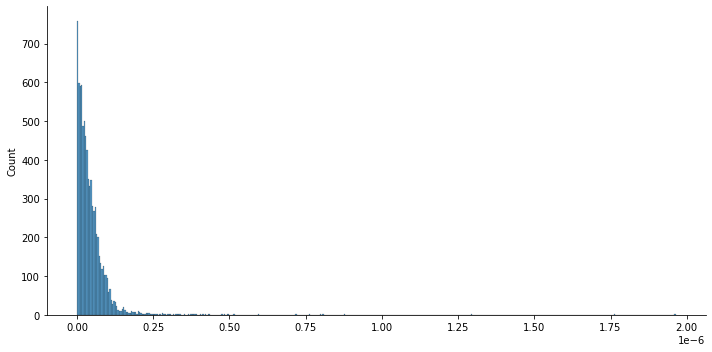

In [68]:
import seaborn as sns

sns.displot(
    prop_errors,
    aspect=2
)

We can do the same thing for the other aggregations of the original data - let's add the median (50% in our table) and the max. Calculating the proportional error in the minimum is tricky, since for many data columns the minimum value will be zero, leading to an infinite proportional error, so we will skip it.

Adding these measurements as additional columns:

In [ ]:
results['mean prop error'] = (results['mean_64'] - results['mean_32']).abs() / results['mean_64_abs']
results['median prop error'] = (results['50%_64'] - results['50%_32']).abs() / results['50%_64_abs']
results['max prop error'] = (results['max_64'] - results['max_32']).abs() / results['max_64_abs']


will allow us to make a summary table:

In [70]:
results[['mean prop error', 'median prop error', 'max prop error']].describe()

,mean prop error,median prop error,max prop error
count,8.038000e+03,7.835000e+03,8.038000e+03
mean,4.340236e-08,1.546485e-08,1.370840e-08
std,5.796892e-08,1.516289e-08,1.422228e-08
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.366587e-08,1.382856e-09,0.000000e+00
50%,3.117527e-08,1.254835e-08,1.014960e-08
75%,5.799712e-08,2.447450e-08,2.442311e-08
max,1.963675e-06,1.067892e-07,5.848003e-08


A little bit of rearrangement using `melt` will allow us to look at the distribution of proportional errors for all three summary statistics:

(0.0, 2e-07)

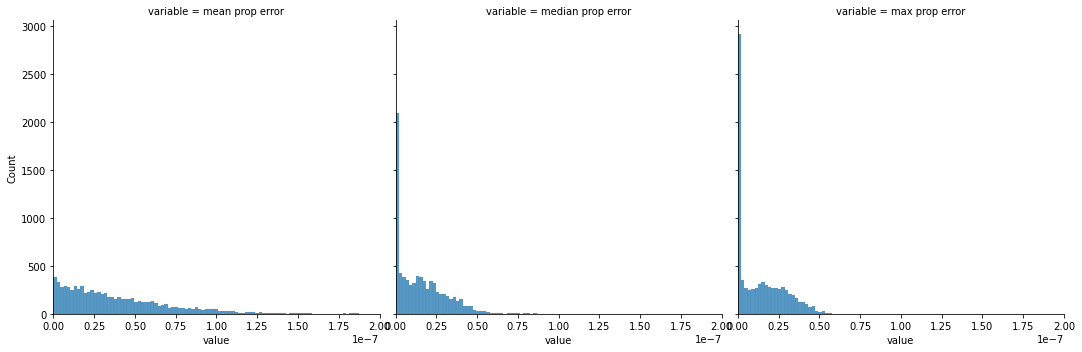

In [71]:
g = sns.displot(
    data = results[['mean prop error', 'median prop error', 'max prop error']].melt(),
    x = 'value',
    col = 'variable',
)

import matplotlib.pyplot as plt
plt.xlim((0, 2e-7))

### Looking at linear regressions

Now we can build a similar dataframe for the linear regression results. The logic is very similar to the summary statistics; we are just using the `summarize_regressions` function instead:

In [ ]:
import glob
from tqdm.notebook import tqdm

dfs = []

for filepath in tqdm(glob.glob('/home/martin/Downloads/kaggle_test/*-*/*.csv')):
    df = get_float_columns(filepath)
    if df is not None:
        summary = summarize_regressions(df)
        if summary is not None:
            summary['filepath'] = filepath
            dfs.append(summary)
        
regressions = pd.concat(dfs)

In [16]:
#hide

regressions.to_csv('regressions.csv', index=False)

If you want to play with the data, you can [download a compressed version here](https://github.com/mojones/dfd_jupyter_test/raw/master/_notebooks/regressions.csv.gz).

The resulting dataframe has the same wide shape as before, but this time each row represents a regression result between two columns from the same data file. We have just over half a million regression results in total:

In [17]:
regressions

,x,y,...,pvalue_32,filepath
0,BMI,DiabetesPedigreeFunction,...,9.197967e-05,/home/martin/Downloads/kaggle_test/uciml-pima-...
0,avg_rating,avg_rating_recent,...,0.000000e+00,/home/martin/Downloads/kaggle_test/jilkothari-...
1,avg_rating,rating,...,0.000000e+00,/home/martin/Downloads/kaggle_test/jilkothari-...
2,avg_rating_recent,rating,...,0.000000e+00,/home/martin/Downloads/kaggle_test/jilkothari-...
0,ts,co,...,1.964217e-60,/home/martin/Downloads/kaggle_test/garystaffor...
...,...,...,...,...,...
401,5a_credit_market_reg,5c_business_reg,...,3.433454e-65,/home/martin/Downloads/kaggle_test/gsutters-ec...
402,5a_credit_market_reg,5_regulation,...,1.517798e-237,/home/martin/Downloads/kaggle_test/gsutters-ec...
403,5b_labor_market_reg,5c_business_reg,...,1.834375e-50,/home/martin/Downloads/kaggle_test/gsutters-ec...
404,5b_labor_market_reg,5_regulation,...,5.207626e-224,/home/martin/Downloads/kaggle_test/gsutters-ec...


Because the number of pairwise comparisons increases with the square of the number of columns, the results are dominated by a small number of data files with many floating point columns:

In [18]:
regressions['filepath'].value_counts()

/home/martin/Downloads/kaggle_test/rajanand-key-indicators-of-annual-health-survey/Key_indicator_districtwise.csv                           182710
/home/martin/Downloads/kaggle_test/uciml-human-activity-recognition-with-smartphones/test.csv                                               157080
/home/martin/Downloads/kaggle_test/uciml-human-activity-recognition-with-smartphones/train.csv                                              157080
/home/martin/Downloads/kaggle_test/johnjdavisiv-us-counties-covid19-weather-sociohealth-data/US_counties_COVID19_health_weather_data.csv     11175
/home/martin/Downloads/kaggle_test/johnjdavisiv-us-counties-covid19-weather-sociohealth-data/us_county_sociohealth_data.csv                   7260
                                                                                                                                             ...  
/home/martin/Downloads/kaggle_test/marcodena-mobile-phone-activity/mi-to-provinces-2013-11-07.csv                     

Out of our 919 data files, only 289 had at least two floating point columns. The data file with the most floating point columns contributes nearly two hundred thousand regression results!

To get an overview of the difference for each property of the regression result, we can add new columns as we did before and summarize them:

In [76]:
regressions['slope error'] = ((regressions['slope_64'] - regressions['slope_32']) / regressions['slope_64']).abs()
regressions['intercept error'] = ((regressions['intercept_64'] - regressions['intercept_32']) / regressions['intercept_64']).abs()
regressions['rvalue error'] = ((regressions['rvalue_64'] - regressions['rvalue_32']) / regressions['rvalue_64']).abs()
regressions['pvalue error'] = ((regressions['pvalue_64'] - regressions['pvalue_32']) / regressions['pvalue_64']).abs()

regressions[['slope error', 'intercept error', 'rvalue error', 'pvalue error']].dropna().describe()

,slope error,intercept error,rvalue error,pvalue error
count,4.181990e+05,4.181990e+05,4.181990e+05,4.181990e+05
mean,4.237303e-04,7.675898e-05,4.237294e-04,1.471530e-06
std,2.486475e-02,1.618511e-02,2.486475e-02,8.407760e-06
min,0.000000e+00,2.753007e-13,0.000000e+00,0.000000e+00
25%,4.304286e-09,1.899837e-08,3.850181e-09,1.095305e-07
50%,1.669817e-08,3.986912e-08,1.547252e-08,3.511528e-07
75%,6.553311e-08,7.240586e-08,6.388698e-08,1.105768e-06
max,4.985437e+00,4.448138e+00,4.985437e+00,2.476720e-03


Notice that in the `count` row we can see how many of the comparisons gave meaningful (i.e. non-missing) output for the linear regressions on both the 64 and 32 bit versions.

Remember that these are proportional errors i.e. the proportion by which the values change. Although the mean errors are a couple of orders of magnitude greater than for the summary statistics, they are still very small, and very unlikely to change any conclusions about the data. 

We have a very long tailed distribution for all four properties: the mean is several orders of magnitude higher than the median (50%) and the maximum values are several orders of magnitude higher again, suggesting a small number of extreme outliers. One way to show this is with a boxen plot:

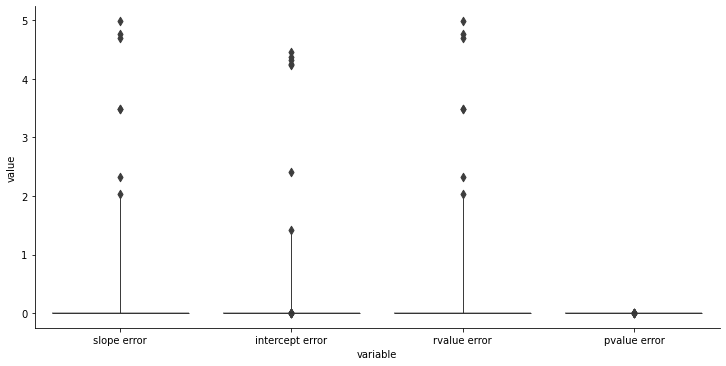

In [77]:
sns.catplot(
    data = regressions[['slope error', 'intercept error', 'rvalue error', 'pvalue error']].dropna().melt(),
    x = 'variable',
    y = 'value',
    kind='boxen',
    aspect = 2
)

The presence of the outliers make it impossible to see the distribution of the remaining values. If we plot the slope against the slope error, we can see that these outliers all represent regressions where the original slope was very near zero, suggesting no interesting relationship between the variables:

(-1e-08, 1e-08)

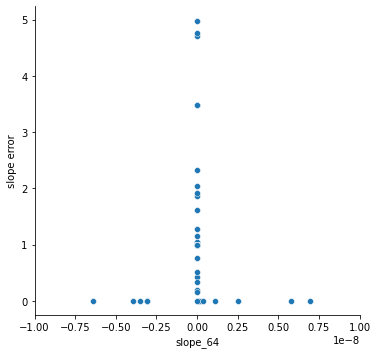

In [78]:
sns.relplot(
    data = regressions,
    x = 'slope_64',
    y = 'slope error'
)

plt.xlim(-1e-8,1e-8)

The same is true for the intercept:

(-1e-05, 1e-05)

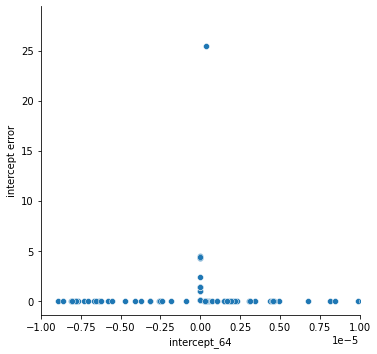

In [79]:
sns.relplot(
    data = regressions,
    x = 'intercept_64',
    y = 'intercept error'
)

plt.xlim(-1e-5,1e-5)

An alternative way of looking at the pvalue error is to ask whether the change in pvalue would result in a difference in whether the relationship was considered significant. Setting aside the problems with interpreting pvalues in this way, we can use pandas to find any regressions where one version of the regression was significant at the 5% level and the other wasn't:

In [81]:
((regressions.dropna()['pvalue_64'] < 0.05) != (regressions.dropna()['pvalue_32'] < 0.05)).value_counts()

False    418199
dtype: int64

In the ~400,000 out of our ~500,000 comparisions that had no missing data, there were no such cases.

## Conclusion

It looks like in real world datasets, switching from 64 bit to 32 bit precision for floating point numbers has a vanishingly small chance of affecting our conclusions, and we should probably do it without fear when trying to minimize memory usage.

If you've made it this far, you should definitely subscribe to the [Drawing from Data newsletter](https://drawingfromdata.com/newsletter/), [follow me on Twitter](https://twitter.com/DataDrawing), or buy the [Drawing from Data book](https://drawingfromdata.com/book/)!